# Bitcoin Price Prediction
Predicting Bitcoin price movement using Logistic Regression, SVM, and XGBoost.
This notebook performs EDA, feature engineering, and model evaluation with visualizations.


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('bitcoin.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,day
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,2014,9,17
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,2014,9,18
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,2014,9,19
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,2014,9,20
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,2014,9,21


In [4]:
df.shape
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2713 non-null   datetime64[ns]
 1   Open       2713 non-null   float64       
 2   High       2713 non-null   float64       
 3   Low        2713 non-null   float64       
 4   Close      2713 non-null   float64       
 5   Adj Close  2713 non-null   float64       
 6   Volume     2713 non-null   int64         
 7   year       2713 non-null   int32         
 8   month      2713 non-null   int32         
 9   day        2713 non-null   int32         
dtypes: datetime64[ns](1), float64(5), int32(3), int64(1)
memory usage: 180.3 KB


,Date,Open,High,Low,Close,Adj Close,Volume,year,month,day
count,2713,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2.713000e+03,2713.000000,2713.000000,2713.000000
mean,2018-06-04 00:00:00.000000256,11311.041069,11614.292482,10975.555057,11323.914637,11323.914637,1.470462e+10,2017.917435,6.592333,15.737560
min,2014-09-17 00:00:00,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06,2014.000000,1.000000,1.000000
25%,2016-07-26 00:00:00,606.396973,609.260986,604.109985,606.718994,606.718994,7.991080e+07,2016.000000,3.000000,8.000000
50%,2018-06-04 00:00:00,6301.569824,6434.617676,6214.220215,6317.609863,6317.609863,5.098183e+09,2018.000000,7.000000,16.000000
75%,2020-04-12 00:00:00,10452.399414,10762.644531,10202.387695,10462.259766,10462.259766,2.456992e+10,2020.000000,10.000000,23.000000
max,2022-02-19 00:00:00,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11,2022.000000,12.000000,31.000000
std,NaN,16106.428891,16537.390649,15608.572560,16110.365010,16110.365010,2.001627e+10,2.164468,3.526507,8.799746


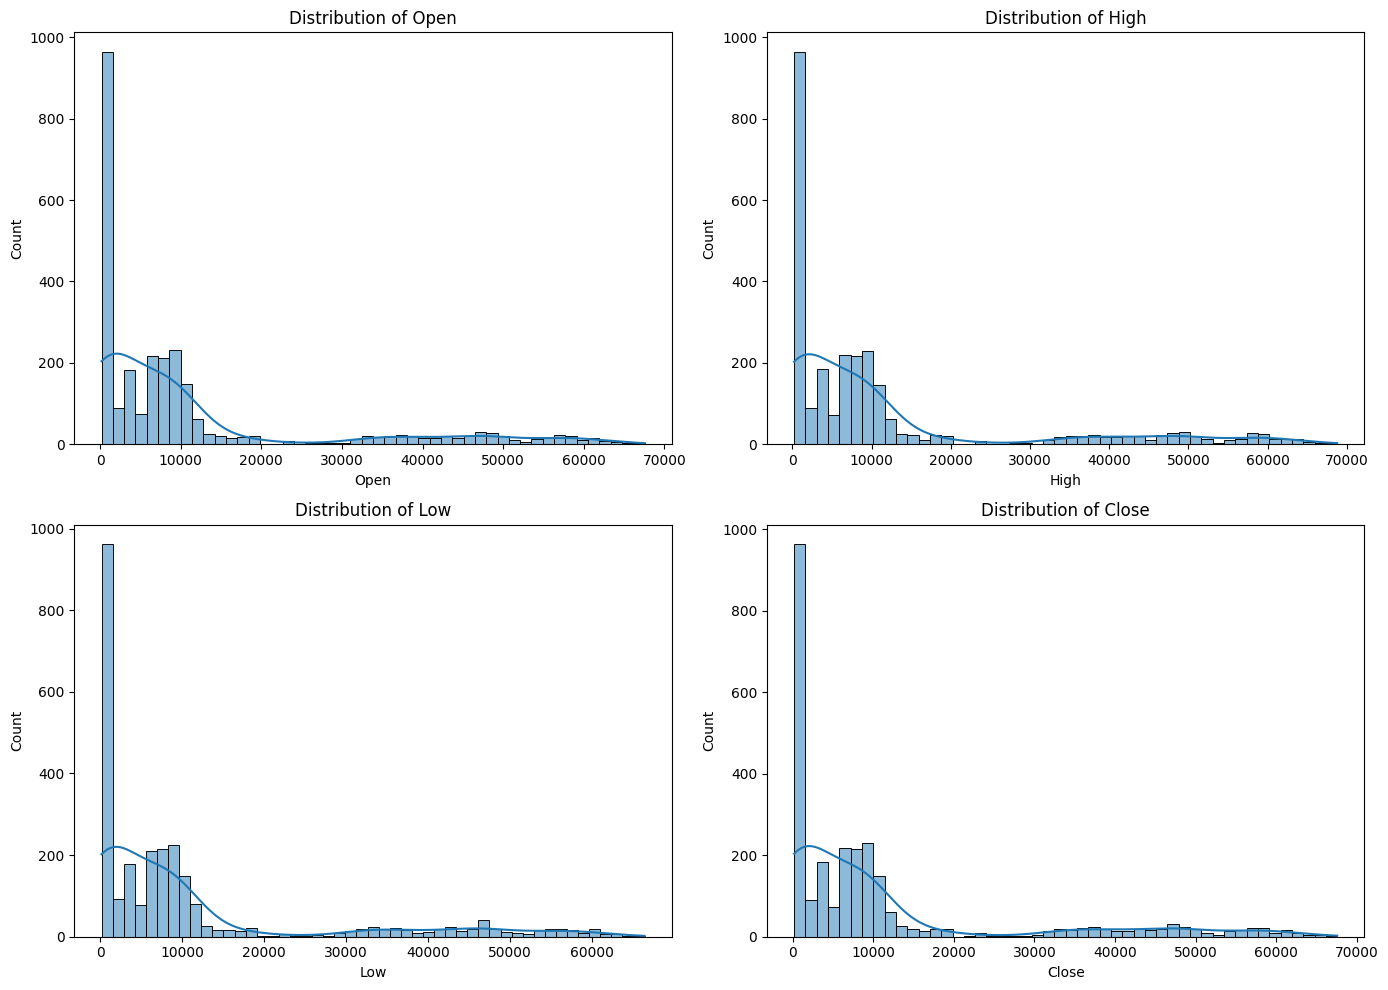

In [4]:
features = ['Open', 'High', 'Low', 'Close']

fig, axes = plt.subplots(2, 2, figsize=(14,10))
for i, col in enumerate(features):
    ax = axes[i//2, i%2]
    sn.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


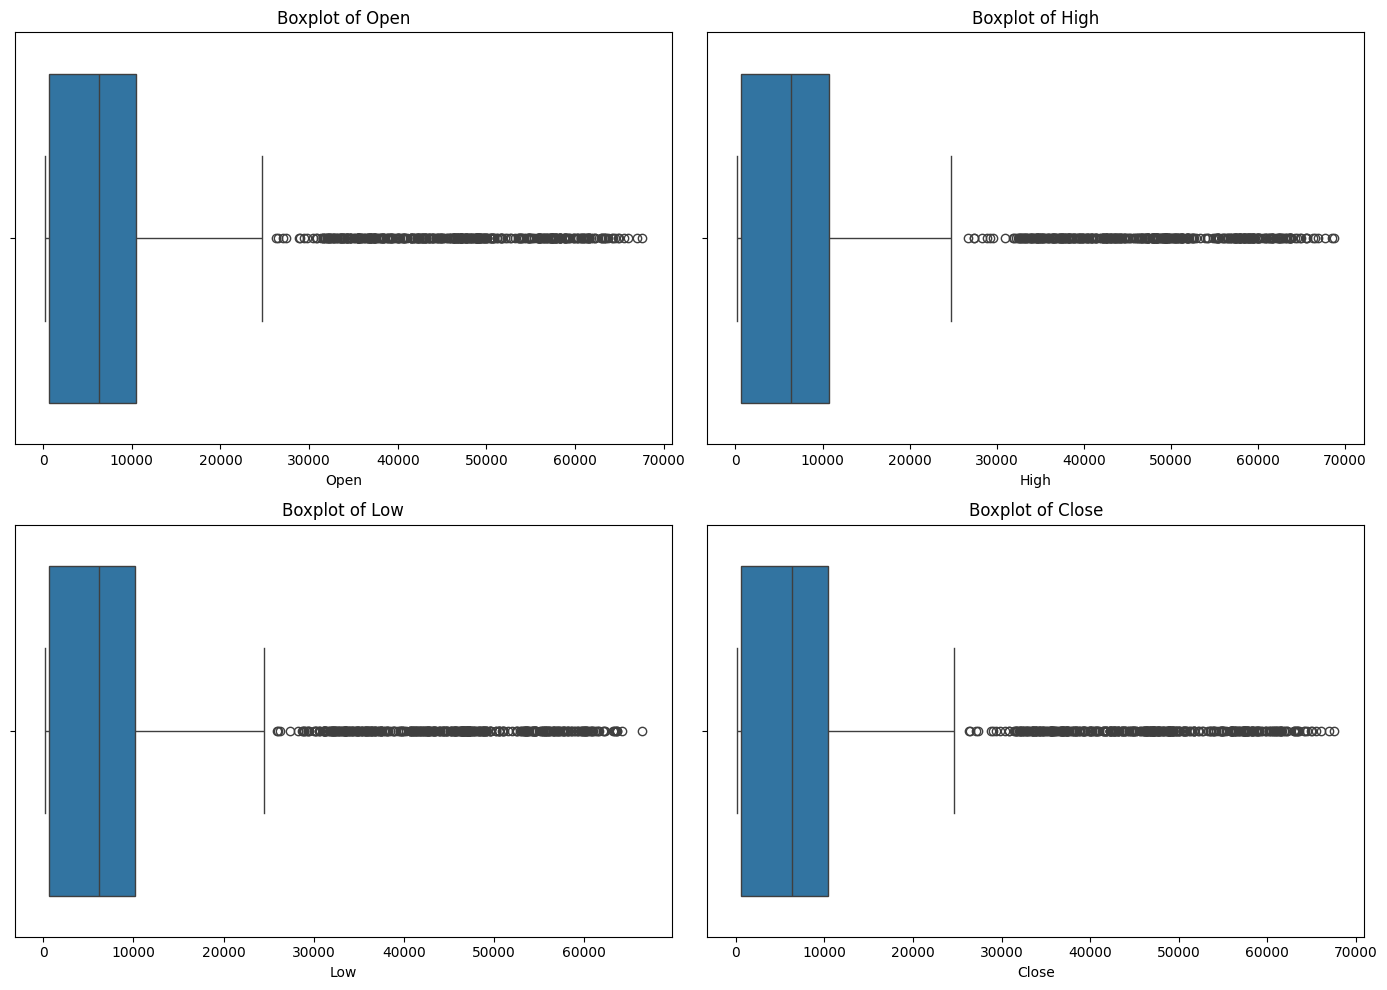

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))
for i, col in enumerate(features):
    ax = axes[i//2, i%2]
    sn.boxplot(x=df[col], ax=ax)
    ax.set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [6]:
df['is_quarter_end'] = np.where(df['month'] % 3 == 0, 1, 0)
df['open-close'] = df['Open'] - df['Close']
df['low-high'] = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

df[['Date','Open','Close','open-close','low-high','is_quarter_end','target']].head()

,Date,Open,Close,open-close,low-high,is_quarter_end,target
0,2014-09-17,465.864014,457.334015,8.529999,-15.752014,1,0
1,2014-09-18,456.859985,424.440002,32.419983,-43.755981,1,0
2,2014-09-19,424.102997,394.795990,29.307007,-43.302978,1,1
3,2014-09-20,394.673004,408.903992,-14.230988,-33.412994,1,0
4,2014-09-21,408.084991,398.821014,9.263977,-19.244995,1,1


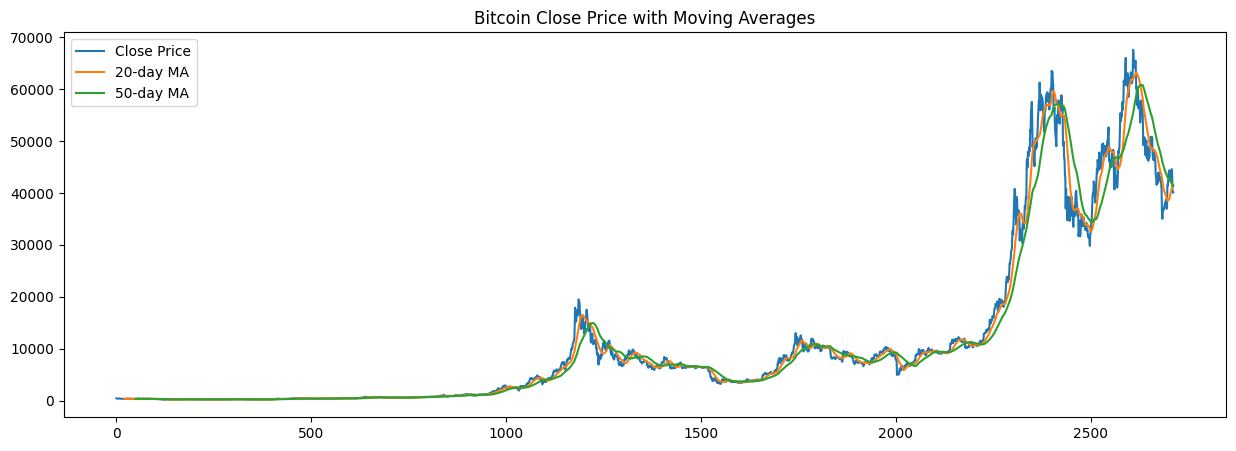

In [7]:
plt.figure(figsize=(15,5))
df['Close'].plot(label='Close Price')
df['MA20'] = df['Close'].rolling(20).mean()
df['MA50'] = df['Close'].rolling(50).mean()
df['MA20'].plot(label='20-day MA')
df['MA50'].plot(label='50-day MA')
plt.title("Bitcoin Close Price with Moving Averages")
plt.legend()
plt.show()


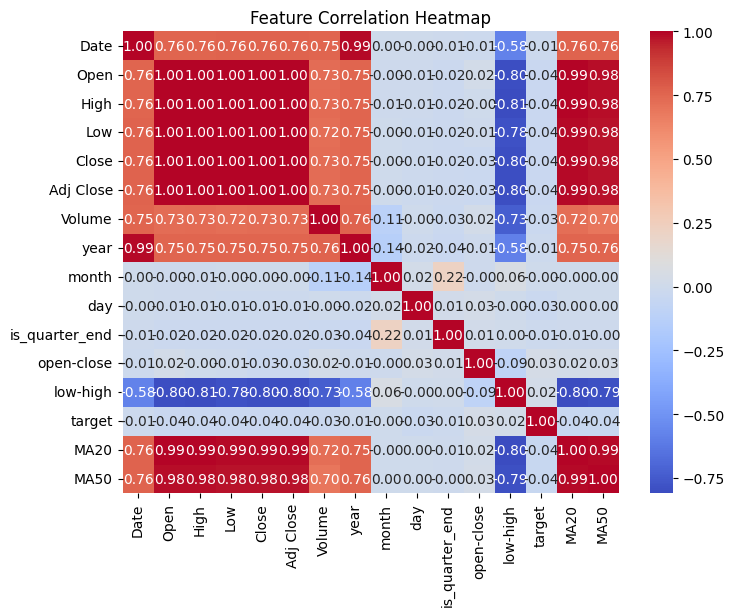

In [8]:
plt.figure(figsize=(8,6))
sn.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [9]:
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid = train_test_split(features_scaled, target, test_size=0.3, random_state=42)


In [10]:
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM (Poly Kernel)": SVC(kernel='poly', probability=True),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

results = {}
for name, model in models.items():
    model.fit(X_train, Y_train)
    train_auc = metrics.roc_auc_score(Y_train, model.predict_proba(X_train)[:,1])
    valid_auc = metrics.roc_auc_score(Y_valid, model.predict_proba(X_valid)[:,1])
    results[name] = (train_auc, valid_auc)
    print(f"{name}: Training AUC = {train_auc:.3f}, Validation AUC = {valid_auc:.3f}")


Logistic Regression: Training AUC = 0.532, Validation AUC = 0.512
SVM (Poly Kernel): Training AUC = 0.534, Validation AUC = 0.529
XGBoost: Training AUC = 0.942, Validation AUC = 0.467


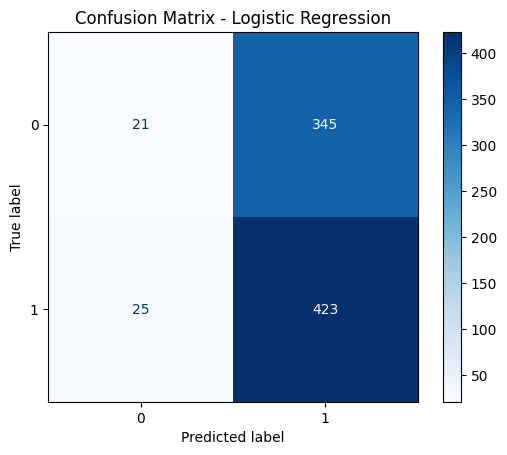

In [11]:
ConfusionMatrixDisplay.from_estimator(models["Logistic Regression"], X_valid, Y_valid, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


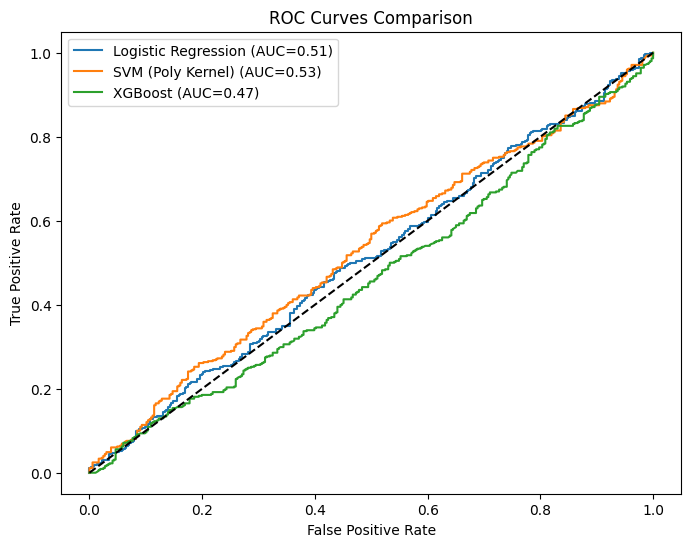

In [12]:
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_proba = model.predict_proba(X_valid)[:,1]
    fpr, tpr, _ = roc_curve(Y_valid, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend()
plt.show()


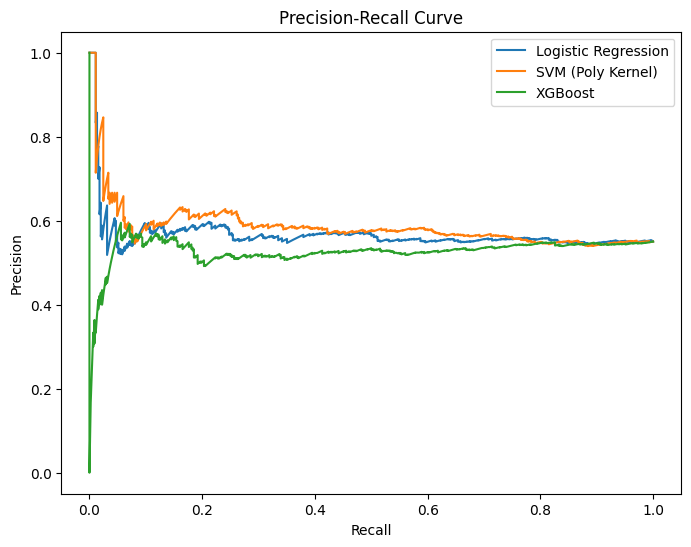

In [13]:
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_proba = model.predict_proba(X_valid)[:,1]
    precision, recall, _ = precision_recall_curve(Y_valid, y_proba)
    plt.plot(recall, precision, label=name)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


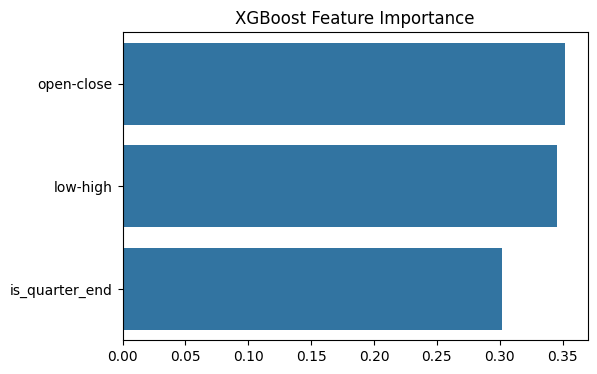

In [14]:
xgb_model = models["XGBoost"]
plt.figure(figsize=(6,4))
sn.barplot(x=xgb_model.feature_importances_, y=['open-close','low-high','is_quarter_end'])
plt.title("XGBoost Feature Importance")
plt.show()


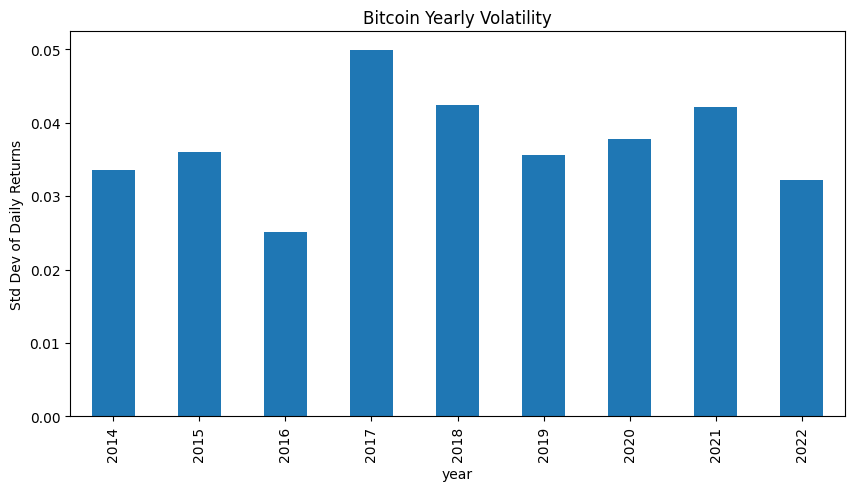

In [15]:
df['daily_return'] = df['Close'].pct_change()
volatility = df.groupby('year')['daily_return'].std()
plt.figure(figsize=(10,5))
volatility.plot(kind='bar')
plt.title("Bitcoin Yearly Volatility")
plt.ylabel("Std Dev of Daily Returns")
plt.show()
